(الف)

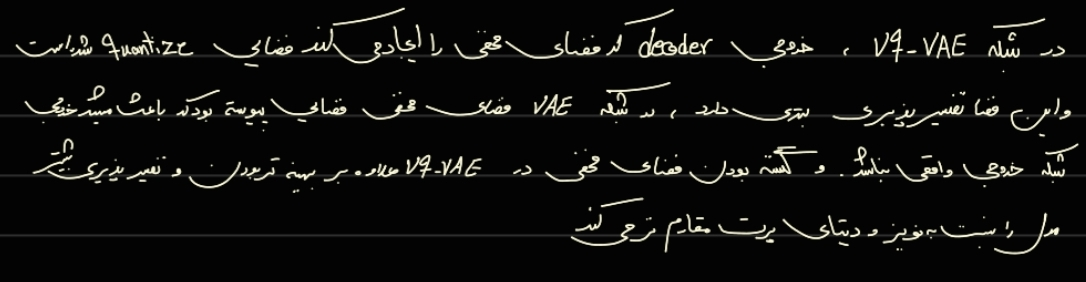

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import imageio.v2 as imageio
import shutil
from IPython.display import Image
import os
plt.style.use('ggplot')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


(ب) Load MNIST dataset

In [4]:
batch_size = 128
transform=transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 83331084.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41104748.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34269149.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18861909.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(ج)

In [5]:
class Residual(nn.Module):
    def __init__(self, in_channels, output_ch, num_residual_hiddens=256):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels = output_ch,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self.block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels,output_ch , num_residual_layers = 2):

        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList([Residual(in_channels,output_ch)
                             for _ in range(self.num_residual_layers)])

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels ):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels= out_channels//2,
                                 kernel_size=4,
                                 stride=2, padding=1) # Same conv
        self.conv_2 = nn.Conv2d(in_channels= out_channels//2,
                                 out_channels= out_channels,
                                 kernel_size=4,
                                 stride=2, padding=1) # Same conv
        self.conv_3 = nn.Conv2d(in_channels= out_channels,
                                 out_channels= out_channels,
                                 kernel_size=3,
                                 stride=1, padding=1) # Same conv
        self.residual_stack = ResidualStack(in_channels= out_channels ,output_ch= out_channels )

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = F.relu(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.conv_3(x)

        out = self.residual_stack(x)
        return out

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels , out_channels, num_hiddens = 256):
        super(Decoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)


        self.residual_stack = ResidualStack(in_channels=num_hiddens, output_ch=num_hiddens)

        self.conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
              out_channels=num_hiddens//2,kernel_size=4,stride=2, padding=1)

        self.conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
              out_channels= out_channels,kernel_size=4,stride=2, padding=1)

    def forward(self, inputs):
        x = self.conv_1(inputs)

        x = self.residual_stack(x)

        x = self.conv_trans_1(x)
        x = F.relu(x)

        return self.conv_trans_2(x)

(د)

In [8]:
class Vector_Quantizer(nn.Module):
    def __init__(self , beta, num_embeddings , embedding_dim ):
        super(Vector_Quantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-0.2, 0.2)
        self.beta = beta

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss
        commitment_loss = F.mse_loss(quantized.detach(), inputs)
        codebook_loss = F.mse_loss(quantized, inputs.detach())
        loss = codebook_loss + self.beta * commitment_loss

        quantized = inputs + (quantized - inputs).detach()  # forward path


        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encodings

In [9]:
class VQModel(nn.Module):
    def __init__(self, input_ch , beta ,embedding_dim ,num_embeddings) :
        super(VQModel, self).__init__()
        num_hiddens = 256
        self.encoder = Encoder(input_ch, num_hiddens)

        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
            out_channels=embedding_dim,kernel_size=1,stride=1)

        self.vq_vae = Vector_Quantizer(beta = beta,
                                       num_embeddings=num_embeddings,embedding_dim=embedding_dim )

        self.decoder = Decoder(in_channels= embedding_dim , out_channels= input_ch)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss, quantized, _ = self.vq_vae(z)
        x_recon = self.decoder(quantized)
        return loss, x_recon

In [10]:
def calculate_variance(loader):
    var_sum = 0
    count = 0
    for images, _ in loader:
        var_sum += torch.var(images)
        count += 1
    return var_sum / count

variance = calculate_variance(train_loader)
print(f'Variance: {variance}')

Variance: 0.09491785615682602


In [11]:
# For last part to make GIF
def codebook_vectors(model,i, images):
  codebook_vectors = model.vq_vae.embedding.weight.detach().cpu().numpy()
  fig, ax = plt.subplots()
  ax.scatter(codebook_vectors[:, 0], codebook_vectors[:, 1])
  ax.set_xlim([-3, 3])
  ax.set_ylim([-3, 3])
  ax.grid(True)
  # Save the plot as an image file
  filename = f'./images/plot_{i}.png'
  plt.savefig(filename)
  plt.close(fig)
  # Append the image file to the list of images
  images.append(imageio.imread(filename))
  return images

In [ ]:
dir_path = './images'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    os.mkdir(dir_path)
else:
    # If it doesn't exist, create the directory
    os.mkdir(dir_path)

(و)






In [ ]:
image_channel = 1
beta = 0.25


num_embedding_vector = 3
dim_embedding_vector = 2

model = VQModel(input_ch=image_channel, beta=beta,
                embedding_dim = dim_embedding_vector,num_embeddings=num_embedding_vector ).to(device)
optimizer = optim.Adam(model.parameters(), lr=8e-4, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_loss = []
images = []
i = 0
for epoch in range(20):

    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon = model(data)

        recon_error = F.mse_loss(data_recon, data) / variance
        loss = recon_error + vq_loss
        train_loss.append(float(loss.item()))
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())

        if i%20 == 0 :
            images = codebook_vectors(model , i , images)
        i+=1
    print('%d Epoch' % (epoch+1))
    print(f'Reconstruction Error:{np.mean(train_res_recon_error[-100:]):3f}',
          f'Loss:{np.mean(train_loss[-100:]):3f} ')



100%|██████████| 469/469 [00:28<00:00, 16.21it/s]


1 Epoch
Reconstruction Error:0.187894 Loss:3.450029 


100%|██████████| 469/469 [00:32<00:00, 14.51it/s]


2 Epoch
Reconstruction Error:0.156432 Loss:1.545713 


100%|██████████| 469/469 [00:27<00:00, 17.02it/s]


3 Epoch
Reconstruction Error:0.146019 Loss:1.114885 


100%|██████████| 469/469 [00:31<00:00, 14.91it/s]


4 Epoch
Reconstruction Error:0.131216 Loss:0.833228 


100%|██████████| 469/469 [00:28<00:00, 16.47it/s]


5 Epoch
Reconstruction Error:0.119691 Loss:0.687627 


100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


6 Epoch
Reconstruction Error:0.113234 Loss:0.602251 


100%|██████████| 469/469 [00:26<00:00, 17.87it/s]


7 Epoch
Reconstruction Error:0.110716 Loss:0.557531 


100%|██████████| 469/469 [00:26<00:00, 17.52it/s]


8 Epoch
Reconstruction Error:0.103972 Loss:0.485992 


100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


9 Epoch
Reconstruction Error:0.097803 Loss:0.444255 


100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


10 Epoch
Reconstruction Error:0.098015 Loss:0.431882 


100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


11 Epoch
Reconstruction Error:0.094140 Loss:0.404455 


100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


12 Epoch
Reconstruction Error:0.092480 Loss:0.392042 


100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


13 Epoch
Reconstruction Error:0.089886 Loss:0.378292 


100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


14 Epoch
Reconstruction Error:0.089215 Loss:0.367674 


100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


15 Epoch
Reconstruction Error:0.087699 Loss:0.366992 


100%|██████████| 469/469 [00:26<00:00, 17.93it/s]


16 Epoch
Reconstruction Error:0.086906 Loss:0.358289 


100%|██████████| 469/469 [00:26<00:00, 17.97it/s]


17 Epoch
Reconstruction Error:0.085445 Loss:0.353114 


100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


18 Epoch
Reconstruction Error:0.084845 Loss:0.346059 


100%|██████████| 469/469 [00:25<00:00, 18.36it/s]


19 Epoch
Reconstruction Error:0.084971 Loss:0.345479 


100%|██████████| 469/469 [00:26<00:00, 17.75it/s]

20 Epoch
Reconstruction Error:0.083555 Loss:0.341688 


In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
loss_list_smooth = savgol_filter(train_loss, 201, 7)

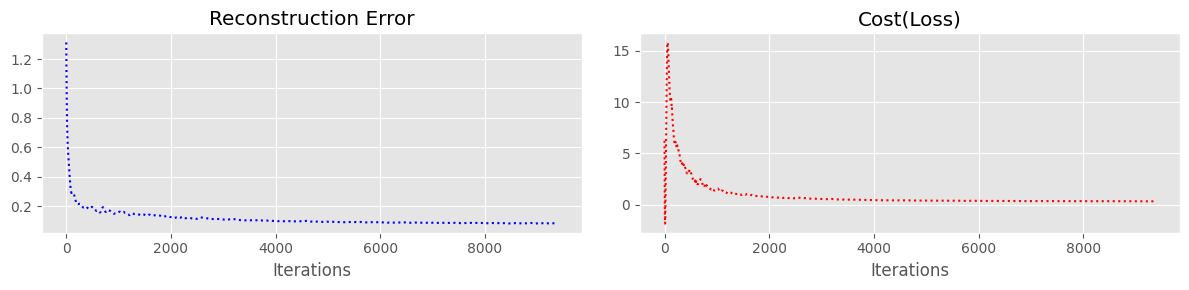

In [ ]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2, 1)
plt.plot(train_res_recon_error_smooth, 'b:')
plt.title('Reconstruction Error')
plt.xlabel('Iterations')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_list_smooth, 'r:')
plt.title('Cost(Loss)')
plt.xlabel('Iterations')
plt.grid(True)

plt.tight_layout()
plt.show()


(ز)

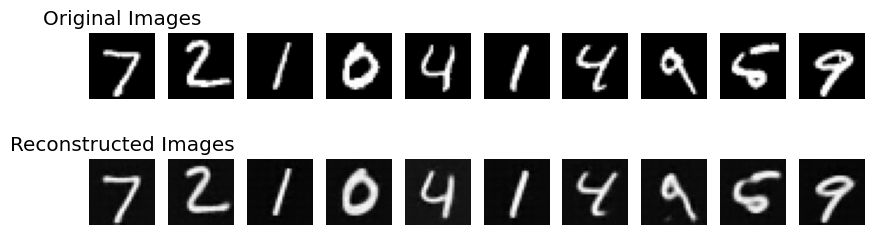

In [ ]:
data, _ = next(iter(test_loader))
data = data.to(device)

with torch.no_grad():
    vq_loss, data_recon = model(data)
    _, _, encodings = model.vq_vae(data_recon)
n = 10  # number of images to display

# Display original images
fig, ax = plt.subplots(2, n, figsize=(n,3))
ax[0,0].set_title('Original Images')
for i in range(n):
    ax[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
    ax[0, i].axis('off')

# Display reconstructed images
ax[1,0].set_title('Reconstructed Images')
for i in range(n):
    ax[1, i].imshow(data_recon[i].cpu().numpy().squeeze(), cmap='gray')
    ax[1, i].axis('off')

plt.show()

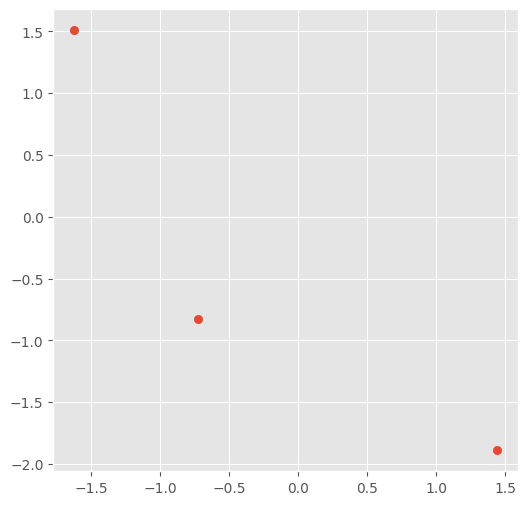

In [ ]:
# Get the codebook vectors
codebook_vectors = model.vq_vae.embedding.weight.detach().cpu().numpy()
# Plot the 2D codebook vectors
plt.figure(figsize=(6, 6))
plt.scatter(codebook_vectors[:, 0], codebook_vectors[:, 1])
plt.show()

(ح)

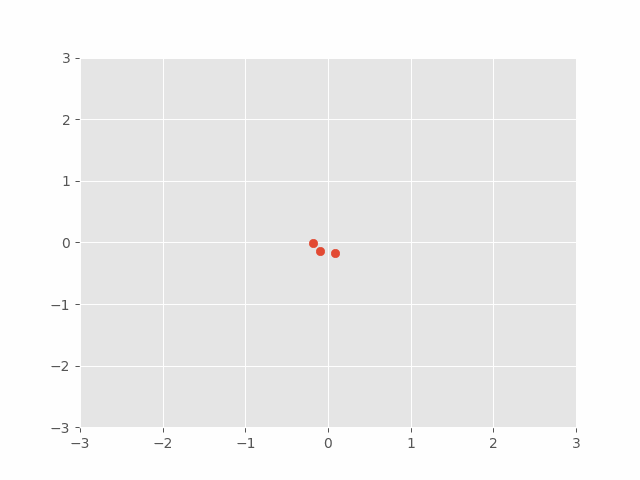

In [ ]:
# Create a GIF from the list of images
imageio.mimsave('codebook_vectors.gif', images, duration=0.00002)
# Load the and show the GIF
with open('codebook_vectors.gif','rb') as file:
    display(Image(file.read()))


(ط)

In [12]:
rgb_images = []
for data,_ in train_dataset:
    R= torch.rand(1) *data
    G= torch.rand(1) *data
    B= torch.rand(1) *data
    rgb_image = torch.cat((R, G, B), dim=0)
    rgb_images.append(rgb_image)

In [13]:
batch_size=128
RGB_dataset =  torch.stack(rgb_images)
RGB_dataloader = DataLoader(rgb_images , batch_size =batch_size)

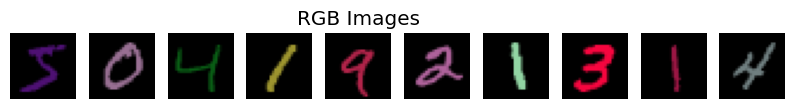

In [14]:
RGB_data = next(iter(RGB_dataloader))
RGB_data = RGB_data.permute(0,2,3,1).to(device)
n = 10  # number of images to display
fig, ax = plt.subplots(1, n, figsize=(n,2))
ax[4].set_title('RGB Images')
for i in range(n):
    ax[i].imshow(RGB_data[i].cpu().numpy().squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

In [15]:
def RGB_show(rec_image, mode , num):
    rec_image = rec_image.permute(0,2,3,1).to(device)
    n = 10  # number of images to display
    fig, ax = plt.subplots(1, n, figsize=(n,3))
    ax[4].set_title(f'reconstructed Images with {mode}={num}')
    for i in range(n):
        image = (rec_image[i].detach().cpu().numpy().squeeze())
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        ax[i].imshow(image, cmap='gray')
        ax[i].axis('off')
    plt.show()


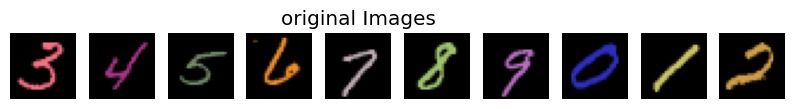

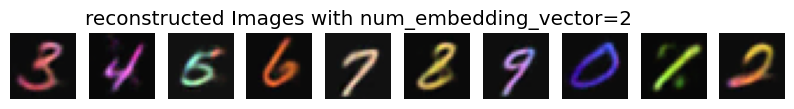

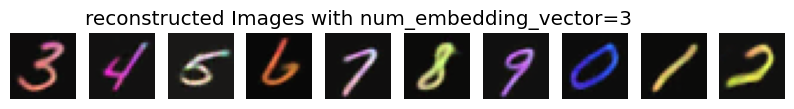

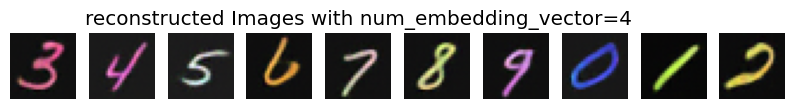

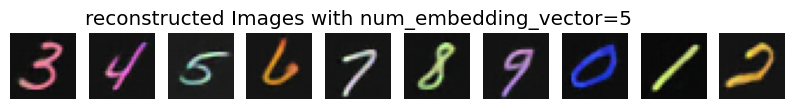

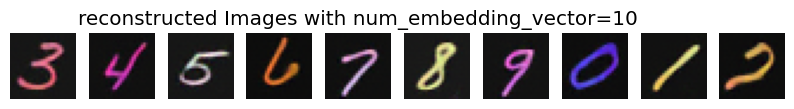

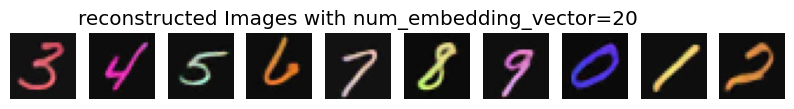

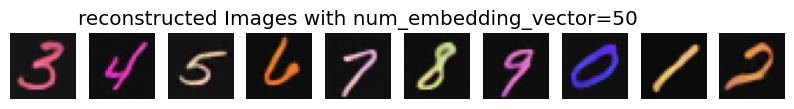

In [16]:
image_channel = 3
beta = 0.25
learning_rate = 8e-4
dim_embedding_vector = 2
start = 2
list_num = [start,3,4,5,10,20,50]
for num_embedding_vector in list_num:
  model = VQModel(input_ch=image_channel,beta=beta,
                embedding_dim = dim_embedding_vector,num_embeddings=num_embedding_vector ).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
  model.train()
  for epoch in range(10):
    for data in (RGB_dataloader):
      data = data.to(device)
      optimizer.zero_grad()
      vq_loss, data_recon = model(data)
      recon_error = F.mse_loss(data_recon, data) / variance
      loss = recon_error + vq_loss
      loss.backward()
      optimizer.step()
  if num_embedding_vector == start:
    fig, ax = plt.subplots(1, 10, figsize=(10,2))
    ax[4].set_title('original Images')
    for i in range(n):
       ax[i].imshow(data[i].permute(1,2,0).cpu().numpy().squeeze(), cmap='gray')
       ax[i].axis('off')
  RGB_show(data_recon, 'num_embedding_vector',num_embedding_vector )






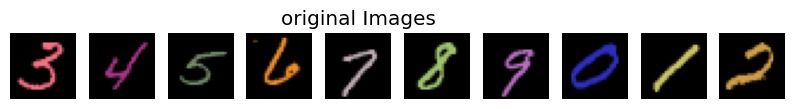

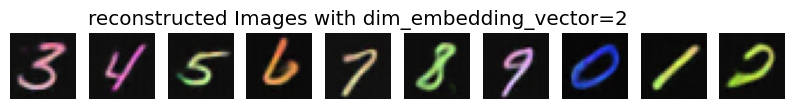

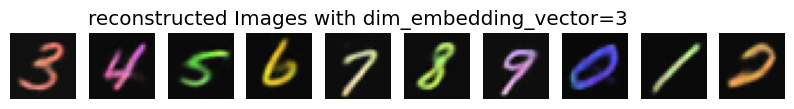

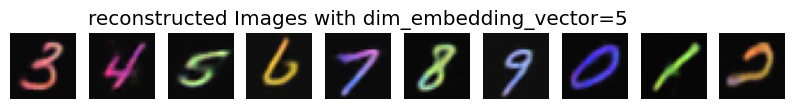

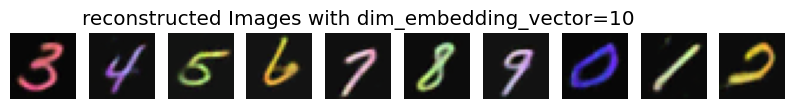

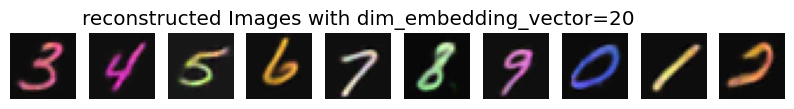

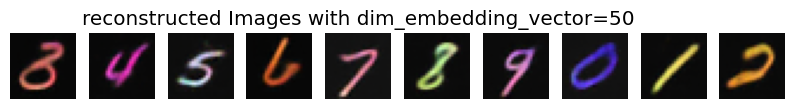

In [17]:
image_channel = 3
beta = 0.25
learning_rate = 8e-4
num_embedding_vector = 3
start = 2

list_num = [start,3,5,10,20,50]

for dim_embedding_vector in list_num:

  model = VQModel(input_ch=image_channel,beta=beta,
                embedding_dim = dim_embedding_vector,num_embeddings=num_embedding_vector ).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
  model.train()
  for epoch in range(10):
    for data in (RGB_dataloader):
      data = data.to(device)
      optimizer.zero_grad()
      vq_loss, data_recon = model(data)
      recon_error = F.mse_loss(data_recon, data) / variance
      loss = recon_error + vq_loss
      loss.backward()
      optimizer.step()

  if dim_embedding_vector == start:
    fig, ax = plt.subplots(1, 10, figsize=(10,2))
    ax[4].set_title('original Images')
    for i in range(n):
        ax[i].imshow(data[i].permute(1,2,0).cpu().numpy().squeeze(), cmap='gray')
        ax[i].axis('off')
  RGB_show(data_recon, 'dim_embedding_vector',dim_embedding_vector )
